In [1]:
import os
import sys
from getpass import getpass
import pathlib
import json
import pandas as pd
import numpy as np
import csv
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

LOCAL_PATH = "/tmp/patent-analysis"
DATA_PATH = os.path.join(LOCAL_PATH, 'dataset')
PERMANENT_STORAGE = "/patent-analysis/dataset"

sys.path.append(LOCAL_PATH)

import dask.dataframe as dask
from dask.distributed import Client

from utils.stats import print_ddf_stats

In [2]:
!python data/uspto_bulk_download.py 


Using TensorFlow backend.
Preparing dataset patent
Preparing dataset uspatentcitation
Preparing dataset location
Preparing dataset assignee
Preparing dataset patent_assignee
Preparing dataset patent_inventor
Preparing dataset persistent_inventor_disambig
sending incremental file list

sent 9.82K bytes  received 19 bytes  19.69K bytes/sec
total size is 9.35G  speedup is 950,313.00


In [ ]:
# !python data/uspto_bulk_download.py \
#         --local_storage=$DATA_PATH \
#         --permanent_storage=$PERMANENT_STORAGE

In [2]:
ncpus = len(os.sched_getaffinity(0))
print("Number of CPUs available:", ncpus)
client = Client(n_workers=32, threads_per_worker=2, memory_limit='6GB', dashboard_address='6006')
client

Number of CPUs available: 64


Client Scheduler: tcp://127.0.0.1:36745 Dashboard: http://127.0.0.1:6006/status,Cluster Workers: 32 Cores: 64 Memory: 192.00 GB


In [3]:
ddf_patent = dask.read_parquet('data/patents-view/patent.parquet')
# print_ddf_stats(ddf_patent)

In [4]:
ddf_patent_inventor = dask.read_parquet('data/patents-view/patent_inventor.parquet')
# print_ddf_stats(ddf_patent_inventor)

In [5]:
ddf_patent_assignee = dask.read_parquet('data/patents-view/patent_assignee.parquet')
# print_ddf_stats(ddf_patent_assignee)

In [6]:
ddf_location = dask.read_parquet('data/patents-view/location.parquet')
# print_ddf_stats(ddf_location)

In [7]:
ddf = ddf_patent.merge(ddf_patent_inventor, how='left', left_index=True, right_index=True)
ddf = ddf.merge(ddf_patent_assignee, how='left', left_index=True, right_index=True)


ddf = ddf.merge(ddf_location.rename(columns=dict(zip(ddf_location.columns, 
                                                     [c + '_inventor' for c in ddf_location.columns]))), 
                how='left', left_on='location_id_inventor', right_on='id')

ddf = ddf.merge(ddf_location.rename(columns=dict(zip(ddf_location.columns, 
                                                     [c + '_assignee' for c in ddf_location.columns]))), 
                how='left', left_on='location_id_assignee', right_on='id')

ddf = ddf.persist()
ddf

,type,number,country,date,title,kind,num_claims,inventor_id,location_id_inventor,assignee_id,location_id_assignee,city_inventor,state_inventor,country_inventor,latitude_inventor,longitude_inventor,county_inventor,city_assignee,state_assignee,country_assignee,latitude_assignee,longitude_assignee,county_assignee
npartitions=119,,,,,,,,,,,,,,,,,,,,,,,
,object,object,object,datetime64[ns],object,object,int16,object,object,object,object,object,object,object,float32,float32,object,object,object,object,float32,float32,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
ddf.head()

,type,number,country,date,title,kind,num_claims,inventor_id,location_id_inventor,assignee_id,...,country_inventor,latitude_inventor,longitude_inventor,county_inventor,city_assignee,state_assignee,country_assignee,latitude_assignee,longitude_assignee,county_assignee
0,utility,10000000,US,2018-06-19,Coherent LADAR using intra-pixel quadrature de...,B2,20,5073021-1,eaa3078f-0dfd-4ddc-8ea3-0057c827e497,org_G6Usf0czKGQH90EpLFrp,...,US,33.884701,-118.410004,Los Angeles,Waltham,MA,US,42.376400,-71.236099,Middlesex
1,utility,10000001,US,2018-06-19,Injection molding machine and mold thickness c...,B2,12,10000001-2,f19948bb-f2cb-4897-a14f-d693b52b7676,org_UyldOHuAOBud968Ru46i,...,KR,37.321899,126.831001,None,Gyeonggi-do,None,KR,37.413799,127.517998,None
2,utility,10000001,US,2018-06-19,Injection molding machine and mold thickness c...,B2,12,7354823-3,44043cd3-222b-41d3-a94d-70949983475e,org_UyldOHuAOBud968Ru46i,...,KR,37.361698,126.934998,None,Gyeonggi-do,None,KR,37.413799,127.517998,None
3,utility,10000002,US,2018-06-19,Method for manufacturing polymer film and co-e...,B2,9,9833943-2,eb686f90-0516-49d3-9fcc-95ea7ca97ad6,org_44j2un8LgVqdcSZ3m0Sg,...,KR,37.241100,127.178001,None,Gwacheon-si,None,KR,37.429199,126.987000,None
4,utility,10000002,US,2018-06-19,Method for manufacturing polymer film and co-e...,B2,9,8388879-3,eb686f90-0516-49d3-9fcc-95ea7ca97ad6,org_44j2un8LgVqdcSZ3m0Sg,...,KR,37.241100,127.178001,None,Gwacheon-si,None,KR,37.429199,126.987000,None


In [255]:
# from math import pi

# import pandas as pd

# from bokeh.io import output_file, show, output_notebook
# from bokeh.palettes import Category20c
# from bokeh.plotting import figure
# from bokeh.transform import cumsum

# output_file("pie.html")
# output_notebook()

# x = dict(100 * assignee_country_counts[:10] / assignee_country_counts.values.sum())

# data = pd.Series(x).reset_index(name='value').rename(columns={'index':'country'})
# data['angle'] = data['value']/data['value'].sum() * 2*pi
# data['color'] = Category20c[len(x)]

# p = figure(plot_height=350, title="Pie Chart", toolbar_location=None,
#            tools="hover", tooltips="@country: @value", x_range=(-0.5, 1.0))

# p.wedge(x=0, y=1, radius=0.4,
#         start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
#         line_color="white", fill_color='color', legend_field='country', source=data)

# p.axis.axis_label=None
# p.axis.visible=False
# p.grid.grid_line_color = None

# show(p)

## Plot the pie-chart of the patent distribution per assignee

In [12]:
assignee_country_counts = ddf.groupby('number')['country_assignee'].first().value_counts().compute()
assignee_country_counts

US    3406937
JP    1306690
DE     394387
KR     272520
TW     177625
       ...   
FJ          1
FK          1
BW          1
TG          1
GY          1
Name: country_assignee, Length: 206, dtype: int64

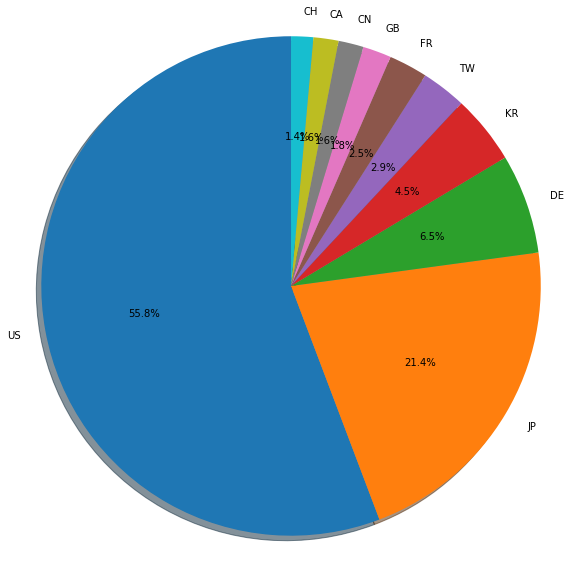

In [250]:
x = dict(100 * assignee_country_counts[:10] / assignee_country_counts.values.sum())


fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(x.values(), labels=x.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

## Plot the pie-chart of the patent distribution per inventor

In [253]:
inventor_country_counts = ddf.groupby('number')['country_inventor'].first().value_counts().compute()
inventor_country_counts

US    3874231
JP    1319830
DE     446399
KR     275035
TW     222234
       ...   
CD          1
VS          1
EK          1
BU          1
ER          1
Name: country_inventor, Length: 244, dtype: int64

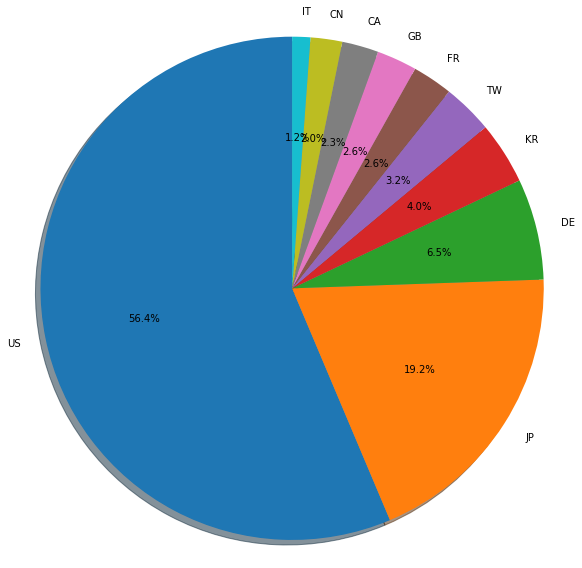

In [256]:
x = dict(100 * inventor_country_counts[:10] / inventor_country_counts.values.sum())


fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(x.values(), labels=x.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

## Plot distribution of patent types and kinds

In [9]:
patent_type = ddf.groupby('number')['type'].first().value_counts().compute()
patent_type

utility                             6824356
design                               654231
plant                                 28219
reissue                               19386
statutory invention registration       2259
defensive publication                   509
TVPP                                      3
Name: type, dtype: int64

In [10]:
patent_type = ddf.groupby('number')['kind'].first().value_counts().compute()
patent_type

B2    3781915
A     2391379
B1     651063
S1     444649
S      209582
P2      13549
E1      10694
E        8692
P        8282
P3       6388
H        1982
I4        509
H1        273
I5          3
H2          3
Name: kind, dtype: int64

## The distribution of the number of inventors per patent

number
10000000    1
10000001    2
10000002    4
10000003    3
10000004    2
           ..
T998013     5
T998014     3
T999001     1
T999002     3
T999003     2
Name: inventor_id, Length: 7528963, dtype: int64


<AxesSubplot:xlabel='inventor_id', ylabel='Count'>

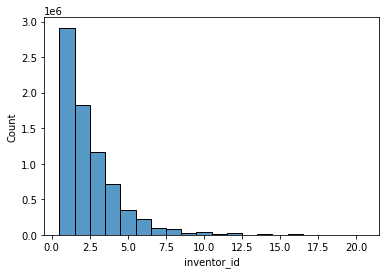

In [9]:
inventor_counts = ddf.groupby('number')['inventor_id'].count().compute()
print(inventor_counts)
sns.histplot(inventor_counts, bins=20, binrange=(1,20), discrete=True)

## The evolution of percentage of patents with a given number of inventors

In [70]:
inventor_counts_time = ddf.groupby(['number']).agg({'date': 'first', 'inventor_id': 'count'}).compute()
inventor_counts_time['year'] = inventor_counts_time['date'].dt.year
inventor_counts_time = pd.DataFrame(
    inventor_counts_time.groupby('year')['inventor_id'].value_counts(normalize=True))

inventor_counts_time = inventor_counts_time.rename(columns={'inventor_id': 'count'}).reset_index()
inventor_counts_time = inventor_counts_time.rename(columns={'inventor_id': 'inventors'})
inventor_counts_time = inventor_counts_time.groupby(['inventors', 'year']).agg({'count': 'first'})

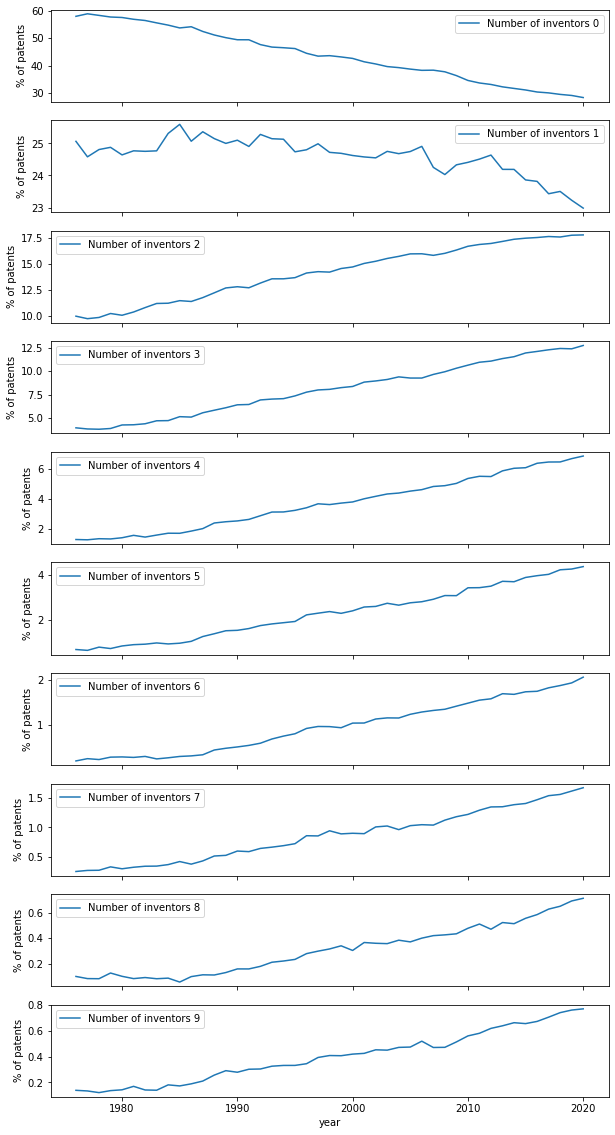

In [89]:
fig, axes = plt.subplots(10, 1, figsize=(10, 20), sharex=True, sharey=False)

for i, inventors in enumerate(range(1, 11)):
    (100*inventor_counts_time.loc[inventors] ).plot(ax=axes[i])
    axes[i].legend([f"Number of inventors {i+1}"])
    axes[i].set_ylabel("% of patents")
    axes[i].set_xlabel("year")

## The evolution of percentage of patents with a given number of geo-locations (cities) involved

In [45]:
geo_counts_time = ddf.map_partitions(lambda x: x.groupby(x.number).agg({'date': 'first', 
                                                                        'state_inventor': "nunique", 
                                                                        'city_inventor': "nunique", 
                                                                        'inventor_id': "nunique"})).compute()
geo_counts_time['year'] = geo_counts_time['date'].dt.year

In [46]:
inventor_counts_time = geo_counts_time.groupby('year')['inventor_id'].value_counts(normalize=True).to_frame()
inventor_counts_time = inventor_counts_time.rename(columns={'inventor_id': 'proportion'}).reset_index()
inventor_counts_time = inventor_counts_time.rename(columns={'inventor_id': 'inventor_count'})
inventor_counts_time = inventor_counts_time.groupby(['inventor_count', 'year']).agg({'proportion': 'first'})

city_counts_time = geo_counts_time.groupby('year')['city_inventor'].value_counts(normalize=True).to_frame()
city_counts_time = city_counts_time.rename(columns={'city_inventor': 'proportion'}).reset_index()
city_counts_time = city_counts_time.rename(columns={'city_inventor': 'city_count'})
city_counts_time = city_counts_time.groupby(['city_count', 'year']).agg({'proportion': 'first'})

inventor_counts_time.head()

proportion
inventor_count year            
0              1976    0.000479
               1977    0.000129
               1978    0.000170
               1979    0.000171
               1980    0.000362

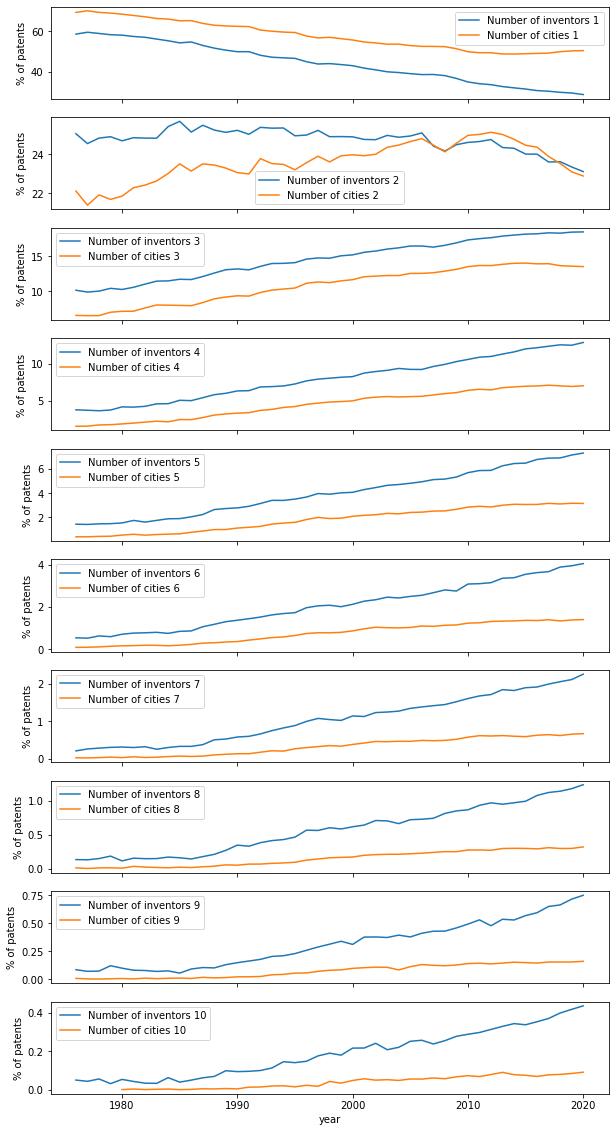

In [47]:
fig, axes = plt.subplots(10, 1, figsize=(10, 20), sharex=True, sharey=False)

for i, count in enumerate(range(1, 11)):
    (100*inventor_counts_time.loc[count] ).plot(ax=axes[i])
    (100*city_counts_time.loc[count] ).plot(ax=axes[i])
    axes[i].legend([f"Number of inventors {i+1}", f"Number of cities {i+1}"])
    axes[i].set_ylabel("% of patents")
    axes[i].set_xlabel("year")